In [1]:
pip install pennylane --upgrade

     |████████████████████████████████| 631 kB 5.2 MB/s 
     |████████████████████████████████| 4.4 MB 33.7 MB/s 


In [2]:
#general import
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# For now a Standard Scaler always applied, if not will be specified
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
#This will change in some cases, KEEP AN EYE!
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

In [4]:
print('Shape X_train:', X_train.shape)
print('Shape Y_train', y_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape Y_test:', y_test.shape)

Shape X_train: (75, 4)
Shape Y_train (75,)
Shape X_test: (25, 4)
Shape Y_test: (25,)


In [5]:
y_test

array([ 1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
       -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.])

# Model 4: Amplitude Encoding and desperate trials to improve the basic

Let's propose again the Amplitude embedding. 2 qubits should be a much better execution cost, but let's see the final accuracy!

In [16]:
from pennylane.templates import AmplitudeEmbedding, BasisEmbedding, DisplacementEmbedding

In [17]:
n_qubits = 2
dev_var = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AmplitudeEmbedding(x, wires=range(n_qubits), normalize = True)

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [18]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

step 0 , loss 0.9000715881154738
step 10 , loss 0.9720120846965464
step 20 , loss 0.9141499044229171
step 30 , loss 0.9200706683637566
step 40 , loss 1.0822483491759538
step 50 , loss 1.031378465640286
step 60 , loss 1.0553209809196922
step 70 , loss 0.8631176512813333
step 80 , loss 1.1339472616986035
step 90 , loss 1.0298319588280758
accuracy on test set: 0.56


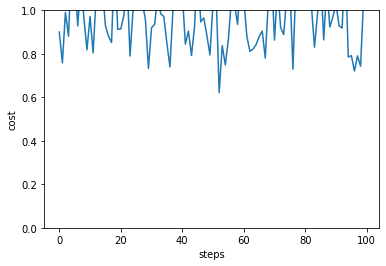

In [12]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

The iterations are way more than the kernel method!

In [13]:
dev_var.num_executions

50025

maybe is a matter of number of layers... let's try

step 0 , loss 0.8420291987076203
step 10 , loss 0.8452588679238524
step 20 , loss 0.9134622729039134
step 30 , loss 1.1888325464312754
step 40 , loss 1.0232441963311691
step 50 , loss 0.8220454499473437
step 60 , loss 0.8452221994629541
step 70 , loss 0.8492819097375444
step 80 , loss 0.940207116636628
step 90 , loss 0.9777765697684421
accuracy on test set: 0.56


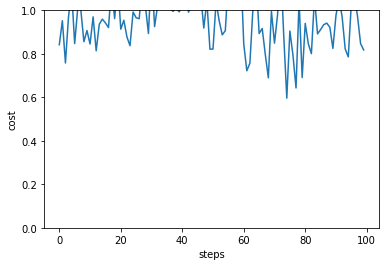

In [19]:
#BEFORE RUNNING THIS CELL YOU HAVE TO REDECLARE THE MODEL IN THE CELLS ABOVE OR IT WILL BE A MESS
n_layers = 4
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [20]:
dev_var.num_executions

98025

Those are too many evaluations on the quantum device! It seems that the encoding actually does a difference!!!